<a href="https://colab.research.google.com/github/kgeunwo77/find_x_project/blob/main/find_waldo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from PIL import Image
from skimage.transform import resize
import threading, random, os
import tensorflow as tf

# 원본 이미지
imgs = np.load('/content/drive/MyDrive/img.npy').astype(np.float32)/255.
# lables: 원본 이미지의 label 이미지, 월리가 없는 곳은 0, 있는 곳은 255
labels = np.load('/content/drive/MyDrive/label.npy').astype(np.float32)/255.
# waldo_sub_imgs: 원본이미지에서 월리가 있는 부분을 crop한 이미지
waldo_sub_imgs = np.load('/content/drive/MyDrive/sub_img.npy',allow_pickle=True)/255.
# waldo_sub_labels: waldo_sub_imgs의 label, 월리가 있는 부분은 255, 아닌 부분은 0
waldo_sub_labels = np.load('/content/drive/MyDrive/sub_label.npy',allow_pickle=True)/255.

print(imgs.shape, labels.shape)
print(waldo_sub_imgs.shape, waldo_sub_labels.shape)

(18, 1792, 828, 3) (18, 1792, 828)
(18, 400, 400, 3) (18, 400, 400)


In [ ]:
class BatchIndices(object):

    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [ ]:
class segm_generator(object):

    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True, waldo=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.waldo = waldo
        self.n = x.shape[0]
        self.ri, self.ci = [], []
        for i in range(self.n):
            ri, ci, _ = x[i].shape
            self.ri.append(ri), self.ci.append(ci) 
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri[idx], self.ro)
        slice_c = self.get_slice(self.ci[idx], self.co)
        x = self.x[idx][slice_r, slice_c]
        y = self.y[idx][slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        if not self.waldo and np.sum(y)!=0:
            return None
        return x, to_categorical(y, num_classes=2).reshape((y.shape[0] * y.shape[1], 2))


    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
        if not items:
            return None
        xs,ys = zip(*tuple(items))
        return np.stack(xs), np.stack(ys)

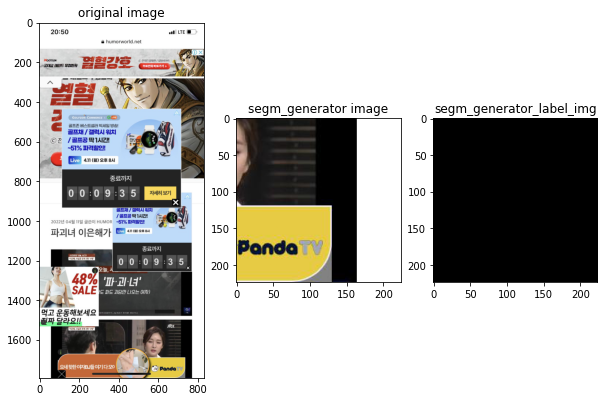

In [ ]:
sg = segm_generator(imgs, labels, 4, train=False)
b_img, b_label = next(sg)
plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(imgs[1])
plt.subplot(1,3,2)
plt.title('segm_generator image')
plt.imshow(b_img[1])
plt.subplot(1,3,3)
plt.title('segm_generator_label_img')
plt.imshow(b_label[1][:,1].reshape(224,224), cmap='gray')

In [ ]:
def seg_gen_mix(x1, y1, x2, y2, tot_bs=4, prop=0.34, out_sz=(224,224), train=True):

    n1 = int(tot_bs*prop)
    n2 = tot_bs - n1
    sg1 = segm_generator(x1, y1, n1, out_sz = out_sz ,train=train)
    sg2 = segm_generator(x2, y2, n2, out_sz = out_sz ,train=train, waldo=False)
    while True:
        out1 = sg1.__next__()
        out2 = sg2.__next__()
        if out2 is None:
            yield out1
        else:
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))

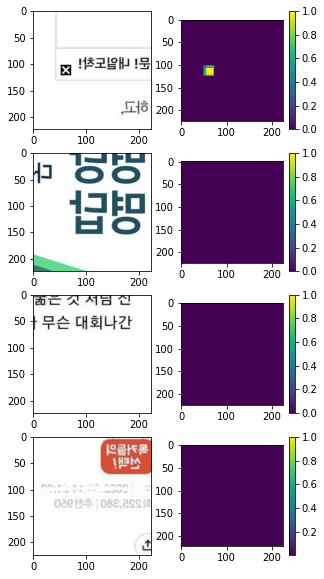

In [ ]:
PANNEL_SIZE= 224
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=4, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

X, y = next(gen_mix)

plt.figure(figsize=(5, 10))
for i, img in enumerate(X):
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i])
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.colorbar()
    plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))

In [ ]:
inputs = layers.Input(shape=(PANNEL_SIZE, PANNEL_SIZE, 3))

net = layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_1 = net

net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_2 = net

net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_3 = net

net = layers.Conv2D(256, kernel_size=1, padding='same')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_3])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_2])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(64, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_1])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(2, kernel_size=1, padding='same')(net)

net = layers.Reshape((-1, 2))(net)
net = layers.Activation('softmax')(net)

model = Model(inputs=inputs, outputs=net)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.Adam(), 
    metrics=['acc'], 
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 224, 224, 64  0           ['conv2d_8[0][0]']               
                                )                                                           

In [ ]:
'''
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=6, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

def on_epoch_end(epoch, logs):
    print('\r', 'Epoch:%5d - loss: %.4f - acc: %.4f' % (epoch, logs['loss'],logs['acc']), end='')

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(
    gen_mix, steps_per_epoch=6, epochs=10, 
    verbose=0,
    callbacks=[
        print_callback,
        ReduceLROnPlateau(monitor='loss', factor=0.2, patience=100, verbose=1, mode='auto', min_lr=1e-05)
    ]
)
'''

"\ngen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=6, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))\n\ndef on_epoch_end(epoch, logs):\n    print('\r', 'Epoch:%5d - loss: %.4f - acc: %.4f' % (epoch, logs['loss'],logs['acc']), end='')\n\nprint_callback = LambdaCallback(on_epoch_end=on_epoch_end)\n\nhistory = model.fit(\n    gen_mix, steps_per_epoch=6, epochs=10, \n    verbose=0,\n    callbacks=[\n        print_callback,\n        ReduceLROnPlateau(monitor='loss', factor=0.2, patience=100, verbose=1, mode='auto', min_lr=1e-05)\n    ]\n)\n"

In [ ]:
from google.colab import files
files.upload()

{}

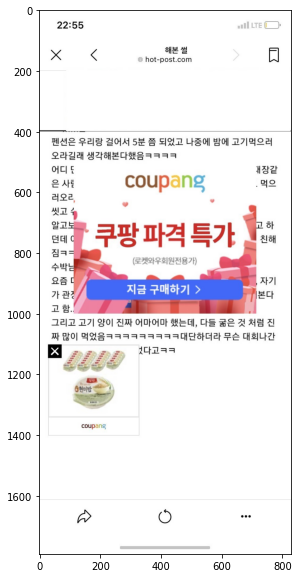

In [ ]:
img_filename='/content/drive/MyDrive/img/3.1.jpg'
test_img = np.array(Image.open(os.path.join(img_filename)).resize((828, 1792), Image.NEAREST)).astype(np.float32) / 255.

plt.figure(figsize=(20, 10))
plt.imshow(test_img)

In [ ]:
def img_resize(img):
  h, w, _ = img.shape
  nvpanels = int(h/PANNEL_SIZE)
  nhpanels = int(w/PANNEL_SIZE)
  new_h, new_w = h, w
  if nvpanels*PANNEL_SIZE != h:
    new_h = (nvpanels+1)*PANNEL_SIZE
  if nhpanels*PANNEL_SIZE != w:
    new_w = (nhpanels+1)*PANNEL_SIZE
  if new_h == h and new_w == w:
    return img
  else:
    return resize(img, output_shape=(new_h, new_w), preserve_range=True)

def split_panels(img):
  h, w, _ = img.shape
  num_vert_panels = int(h/PANNEL_SIZE)
  num_hor_panels = int(w/PANNEL_SIZE)
  panels = []
  for i in range(num_vert_panels):
    for j in range(num_hor_panels):
      panels.append(img[i*PANNEL_SIZE:(i+1)*PANNEL_SIZE,j*PANNEL_SIZE:(j+1)*PANNEL_SIZE])
  return np.stack(panels)

def combine_panels(img, panels):
  h, w, _ = img.shape
  num_vert_panels = int(h/PANNEL_SIZE)
  num_hor_panels = int(w/PANNEL_SIZE)
  total = []
  p = 0
  for i in range(num_vert_panels):
    row = []
    for j in range(num_hor_panels):
      row.append(panels[p])
      p += 1
    total.append(np.concatenate(row, axis=1))
  return np.concatenate(total, axis=0)
test_img = img_resize(test_img)

panels = split_panels(test_img)

out = combine_panels(test_img, panels)

print(panels.shape, test_img.shape, out.shape)

(32, 224, 224, 3) (1792, 896, 3) (1792, 896, 3)


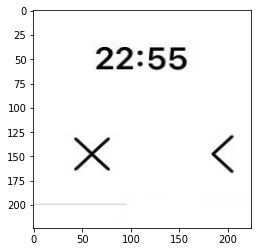

In [ ]:
plt.imshow(panels[0])

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/saved_model.h5')

(34, 1104) 18.45%


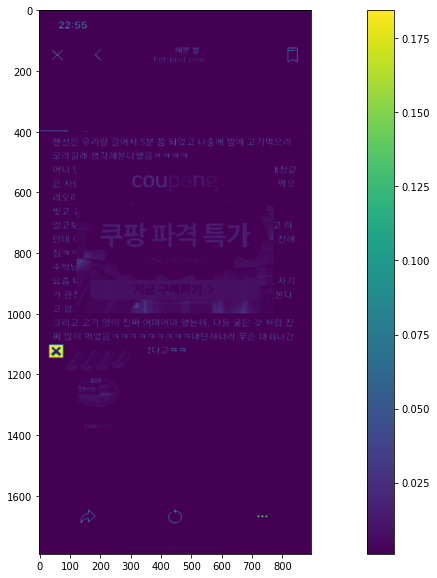

In [ ]:
pred_panels = model.predict(panels).reshape((-1, PANNEL_SIZE, PANNEL_SIZE, 2))[:, :, :, 1]

pred_out = combine_panels(test_img, pred_panels)

# compute coordinates and confidence
argmax_x = np.argmax(np.max(pred_out, axis=0), axis=0)
argmax_y = np.argmax(np.max(pred_out, axis=1), axis=0)
confidence = np.amax(pred_out) * 100

print('(%s, %s) %.2f%%' % (argmax_x, argmax_y, confidence))

plt.figure(figsize=(20, 10))
plt.imshow(pred_out)
plt.colorbar()

34 1104 77 1143


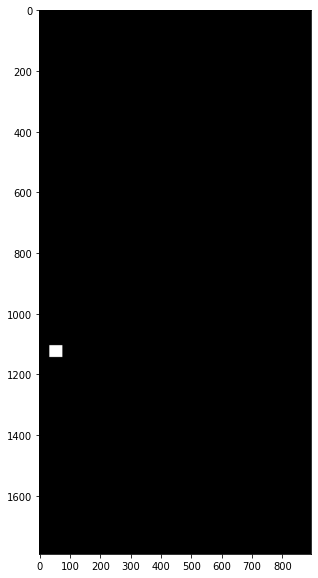

In [ ]:
def bbox_from_mask(img):
  rows = np.any(img, axis=1)
  cols = np.any(img, axis=0)
  y1, y2 = np.where(rows)[0][[0, -1]]
  x1, x2 = np.where(cols)[0][[0, -1]]
  return x1, y1, x2, y2

x1, y1, x2, y2 = bbox_from_mask((pred_out>0.18).astype(np.uint8))
print(x1, y1, x2, y2)

# make overlay
overlay = np.repeat(np.expand_dims(np.zeros_like(pred_out, dtype=np.uint8), axis=-1), 3, axis=-1)
alpha = np.expand_dims(np.full_like(pred_out, 255, dtype=np.uint8), axis=-1)

overlay = np.concatenate([overlay, alpha], axis=-1)

overlay[y1:y2, x1:x2, 3] = 0

plt.figure(figsize=(20, 10))
plt.imshow(overlay)

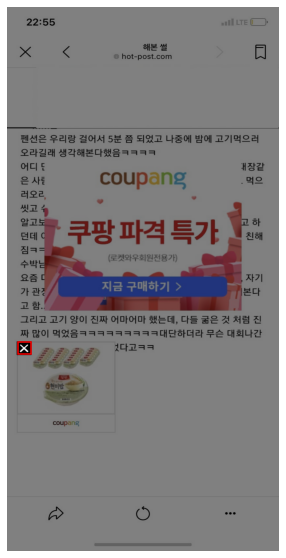

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(test_img)
ax.imshow(overlay, alpha=0.5)

rect = patches.Rectangle((x1, y1), width=x2-x1, height=y2-y1, linewidth=1.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)

ax.set_axis_off()